In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import scipy.io
from exputils import load_multiple_sessions, load_session, make_savedict
npr.seed(0)

import ssm
from ssm.util import find_permutation, split_by_trials
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib notebook

# Speficy whether or not to save figures
save_figures = True

%reload_ext autoreload
%autoreload 2

In [31]:
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 2    # number of discrete states
obs_dim = 30       # dimensionality of observation

# Make an HMM
np.random.seed(128)
true_hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

true_hmm.observations.mus = np.array([1, 9]).T
true_hmm.observations.sigmas = np.array([0.8, 1.5]).T
true_hmm.observations.lapses = np.array([0.3, 0.1]).T


# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

arr=  true_hmm.observations.log_likelihoods(obs, None, None, None)

true_ll = true_hmm.log_probability(obs)

In [41]:
true_hmm.log_probability(obs)

-13257.175966764022

In [42]:
hmm.log_probability(obs)

-13253.18495069711

<IPython.core.display.Javascript object>


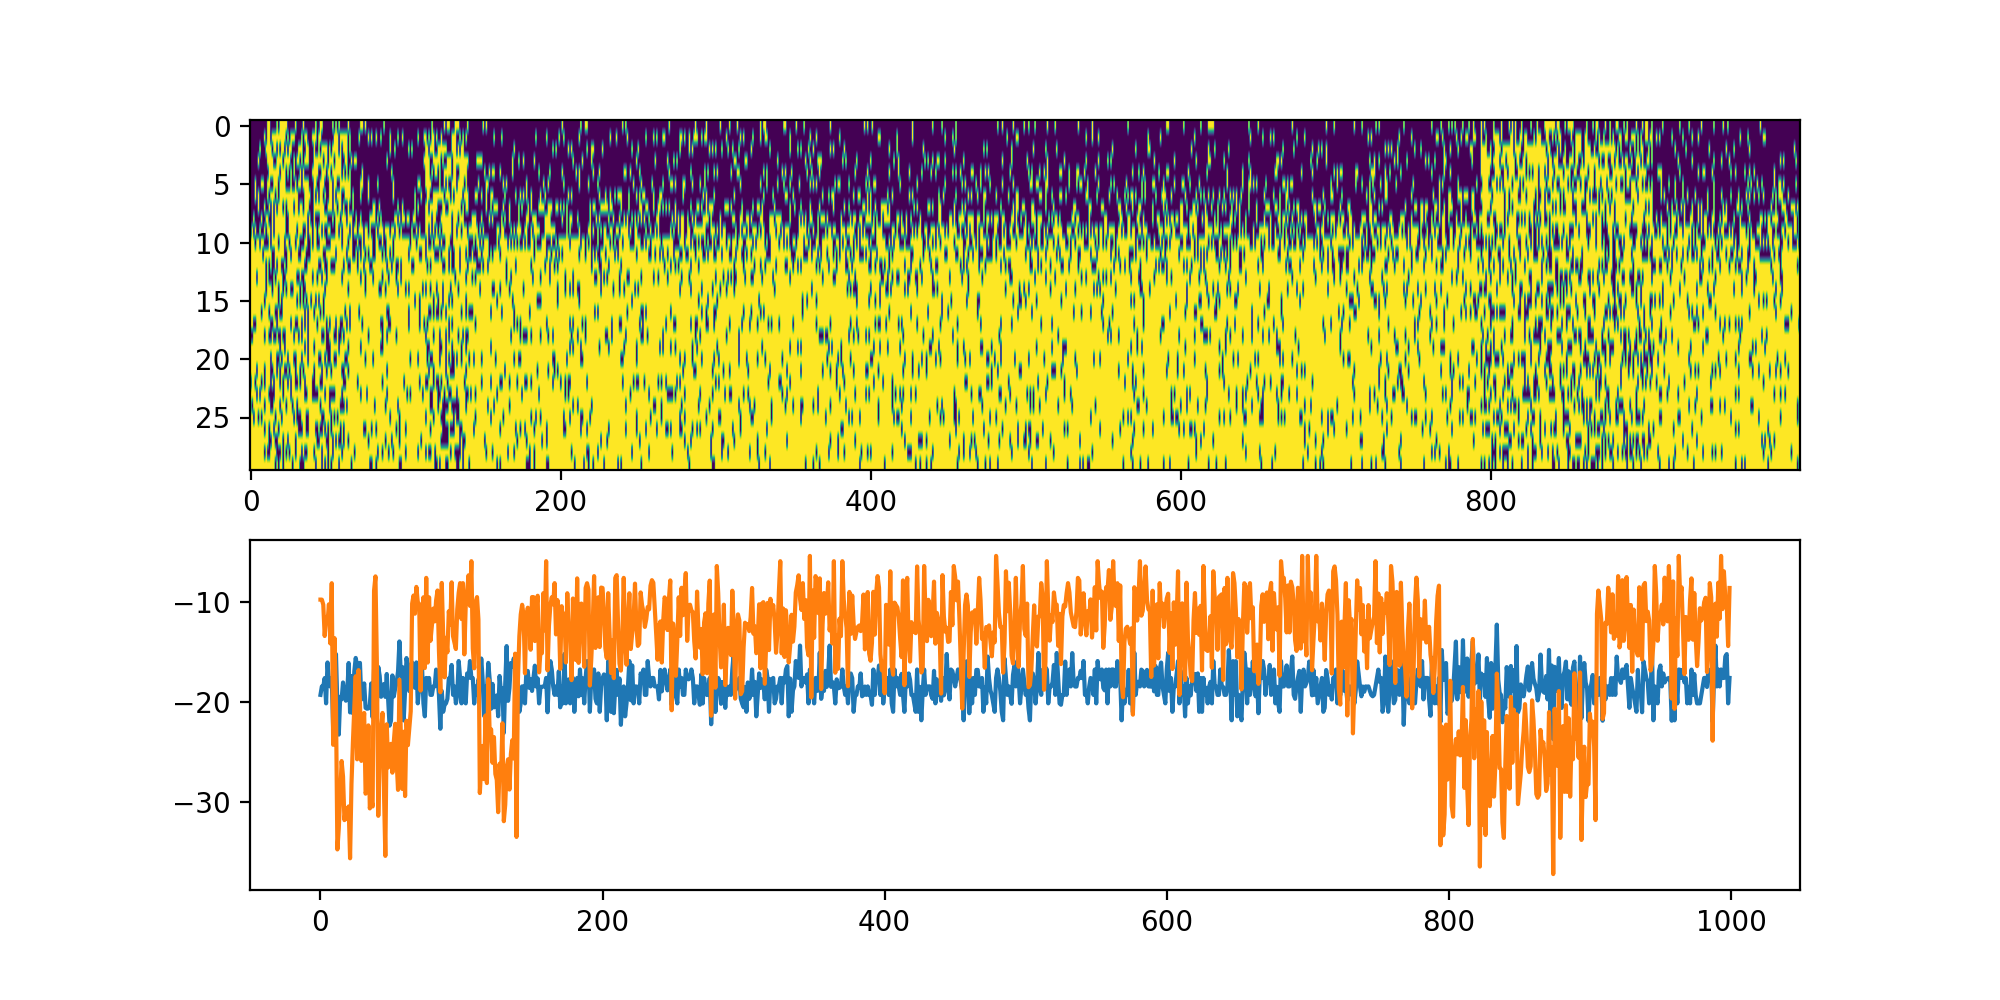

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.imshow(obs.T, aspect='auto')
plt.subplot(212)
plt.plot(arr)

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


  0%|          | 0/20000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


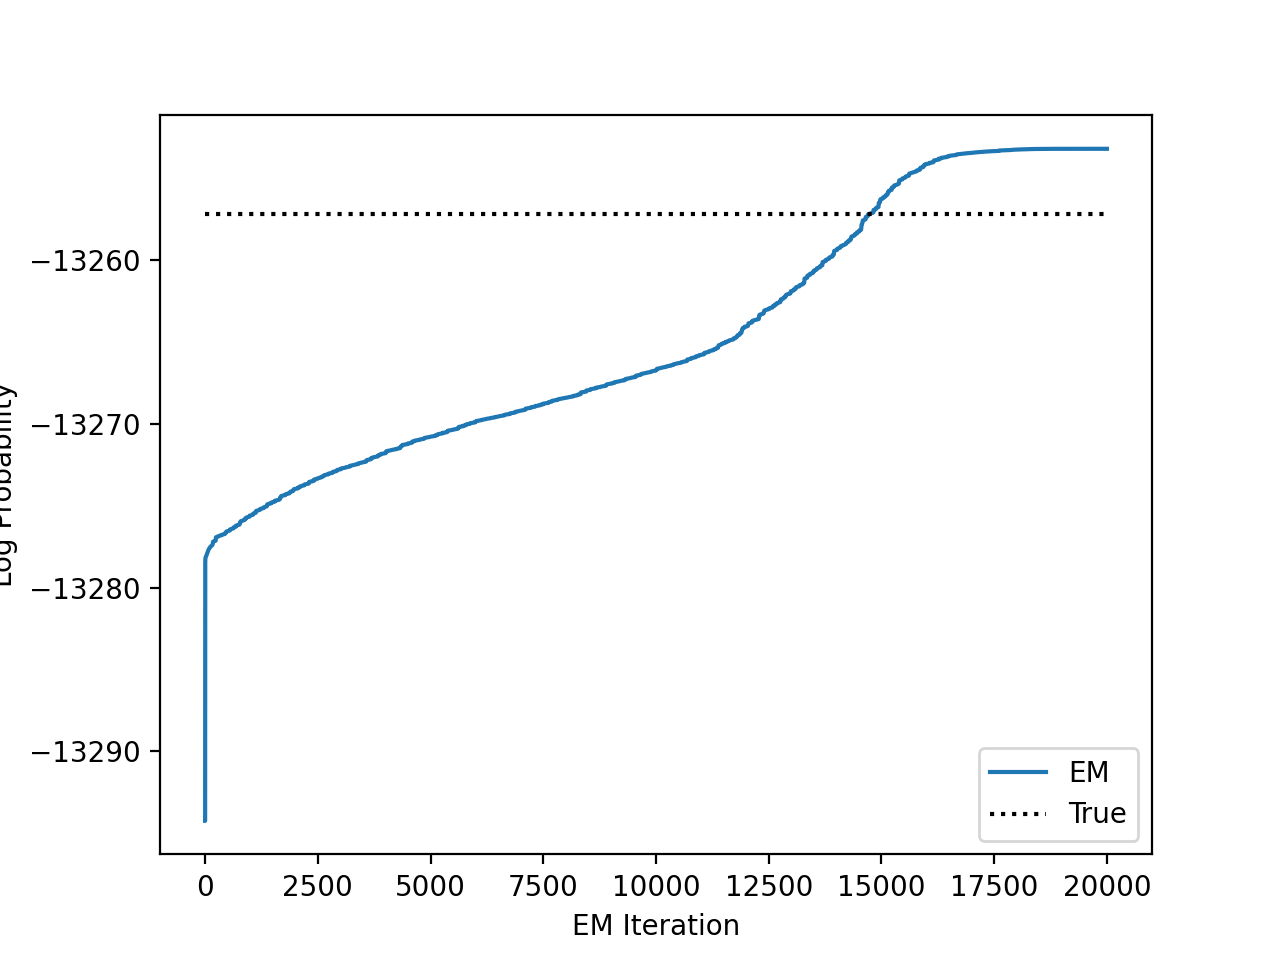

In [37]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 20000

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.figure()
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


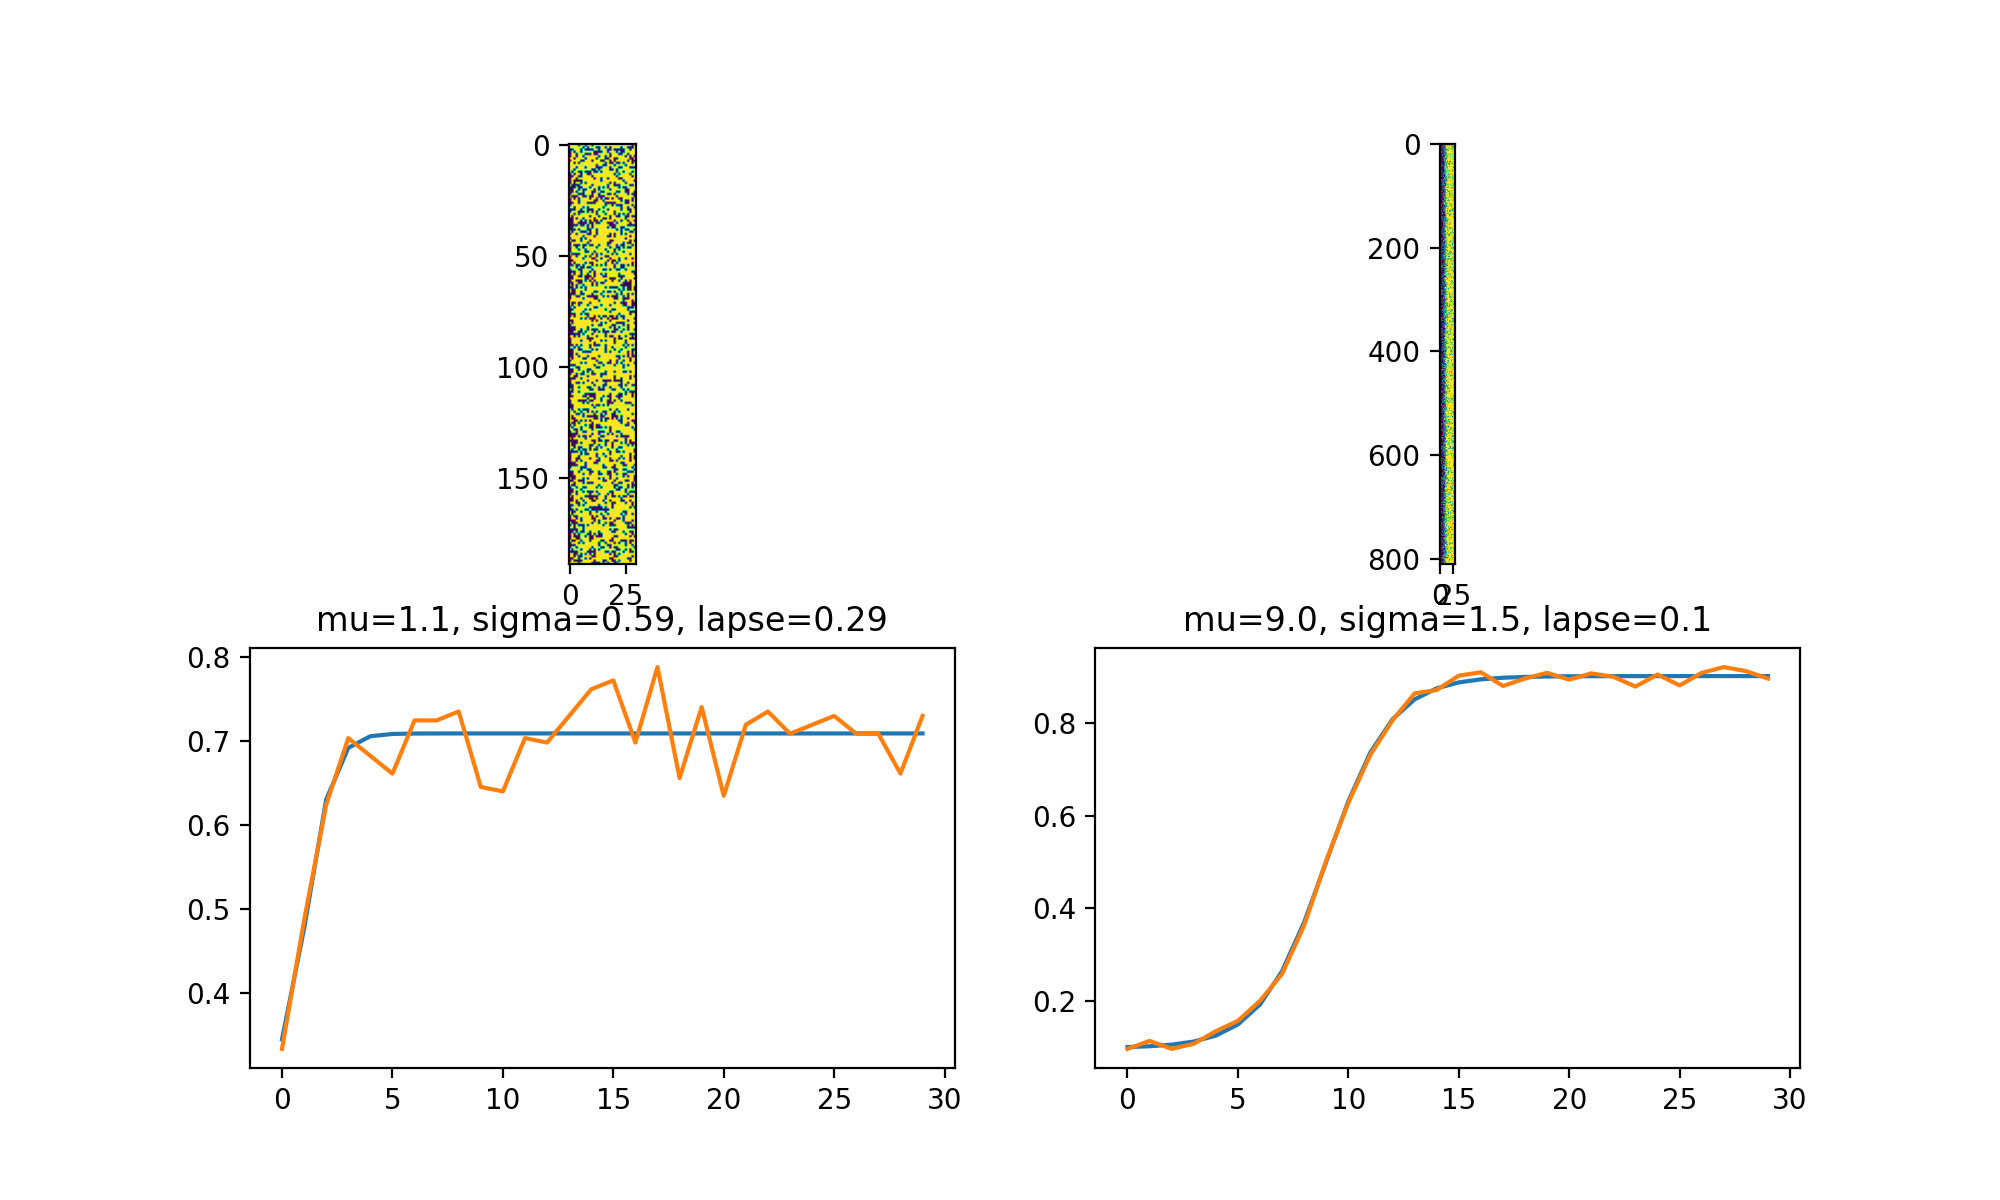

In [38]:
def sigmoid(x, mu, sigma, lapse=0):
    return lapse + (1-2*lapse) / (1 + np.exp(-(x - mu) / sigma))

# hmm.permute([1,3,0,2])

# Pool states and visualize
zstates = hmm.most_likely_states(obs)
obs_clustered = list(map(lambda x: obs[(zstates == x),:], np.unique(zstates)))

# Construct the block transition function for each mode
mus, sigmas, lapses = hmm.observations.params

transfuncs = list(map(lambda mu,sigma, lapse: sigmoid(np.arange(hmm.D), mu, sigma, lapse), mus, sigmas, lapses))
plt.figure(figsize=(10,6))

for i in range(num_states):
    plt.subplot(2,num_states,i+1)
    plt.imshow(obs_clustered[i])
    
    plt.subplot(2, num_states, i+1+num_states)
    plt.plot(transfuncs[i])
    plt.plot(np.nanmean(obs_clustered[i], axis=0))
    
    plt.title(f'mu={mus[i][0]:.2}, sigma={sigmas[i][0]:.2}, lapse={lapses[i][0]:.2}')
    


In [39]:
hmm.observations.params

(array([[1.13251113],
        [8.99430252]]),
 array([[0.59302879],
        [1.48025388]]),
 array([[0.29071507],
        [0.09952466]]))

In [40]:
true_hmm.observations.params

(array([1, 9]), array([0.8, 1.5]), array([0.3, 0.1]))

<IPython.core.display.Javascript object>


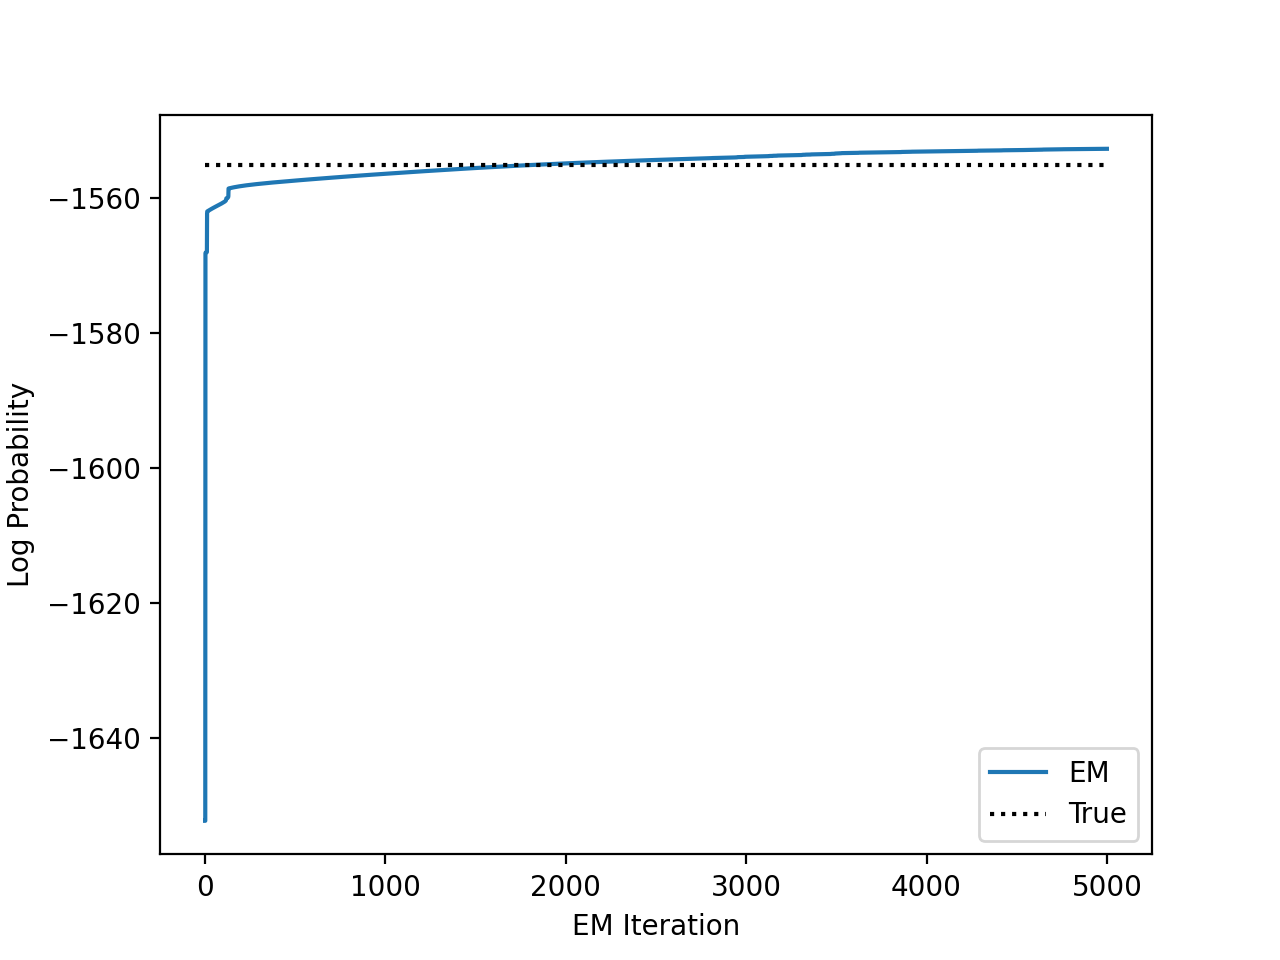

In [23]:
plt.figure()
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [36]:
hmm.observations.params

(array([[1.4943444 ],
        [4.16464071],
        [0.41807052]]),
 array([[0.80326436],
        [0.79832153],
        [8.09854573]]),
 array([[0.28089093],
        [0.01      ],
        [0.68593411]]))

In [34]:
true_hmm.observations.params

(array([1, 4, 9]), array([0.8, 0.8, 0.8]), array([0.3, 0. , 0. ]))

In [7]:
find_permutation(np.array([0,1,2,2]), np.array([2,1,1,1]))

array([2, 0, 1])

In [8]:
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

<IPython.core.display.Javascript object>


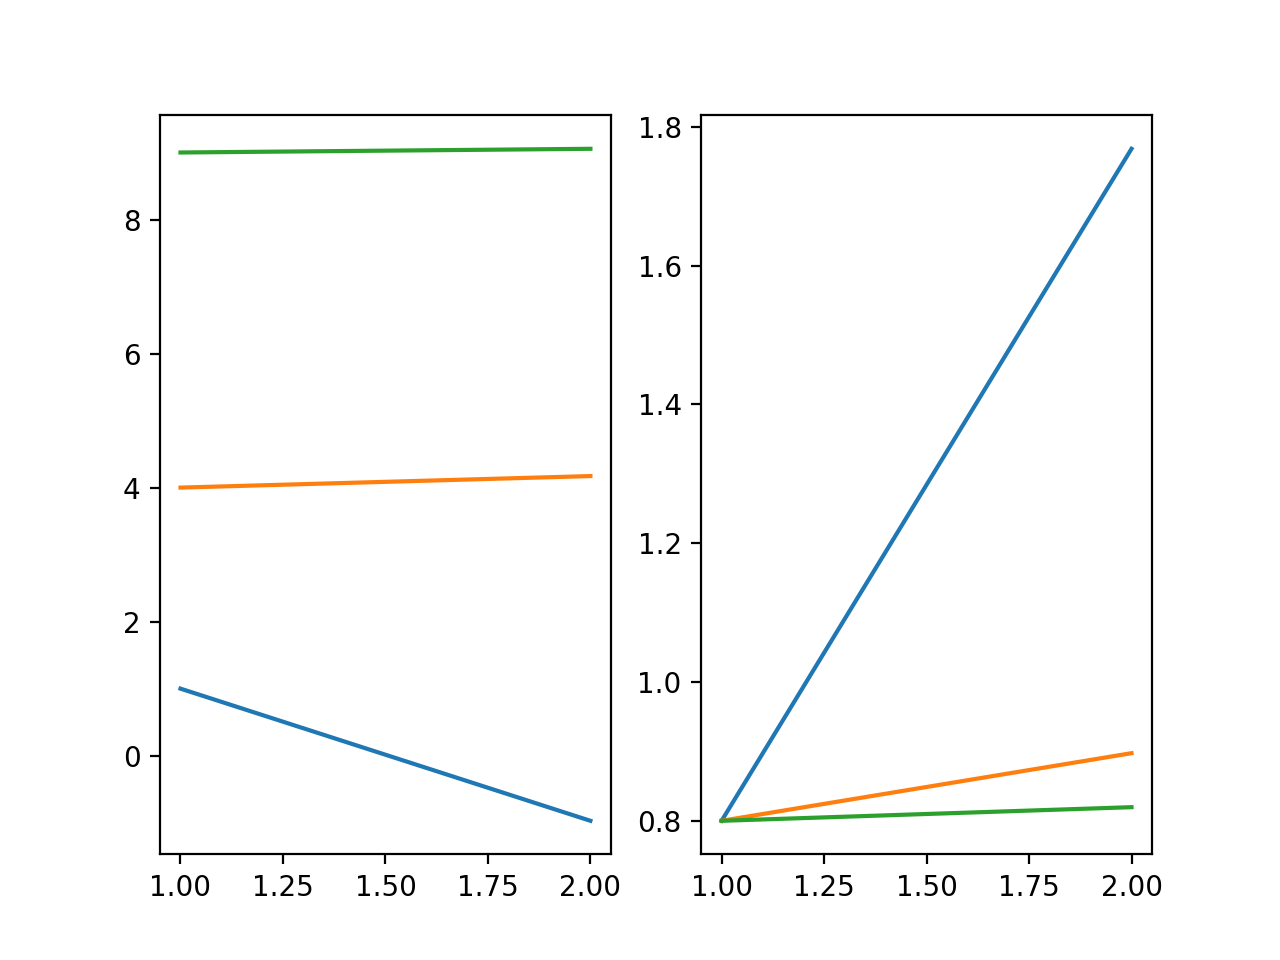

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [14]:
# Comparing the true and inferred parameters
true_mus, true_sigmas = true_hmm.observations.params
sim_mus, sim_sigmas = hmm.observations.params


plt.figure()
plt.subplot(121)
for i in range(3):
    plt.plot([1,2], [true_mus[i], sim_mus[i]])
    
plt.subplot(122)
for i in range(3):
    plt.plot([1,2], [true_sigmas[i], sim_sigmas[i]])

In [110]:
learned_transition_mat

array([[1.25177208e-02, 1.48346513e-02, 9.72647628e-01],
       [1.97515289e-32, 6.34862552e-01, 3.65137448e-01],
       [2.71227471e-01, 3.72005646e-01, 3.56766884e-01]])

<IPython.core.display.Javascript object>


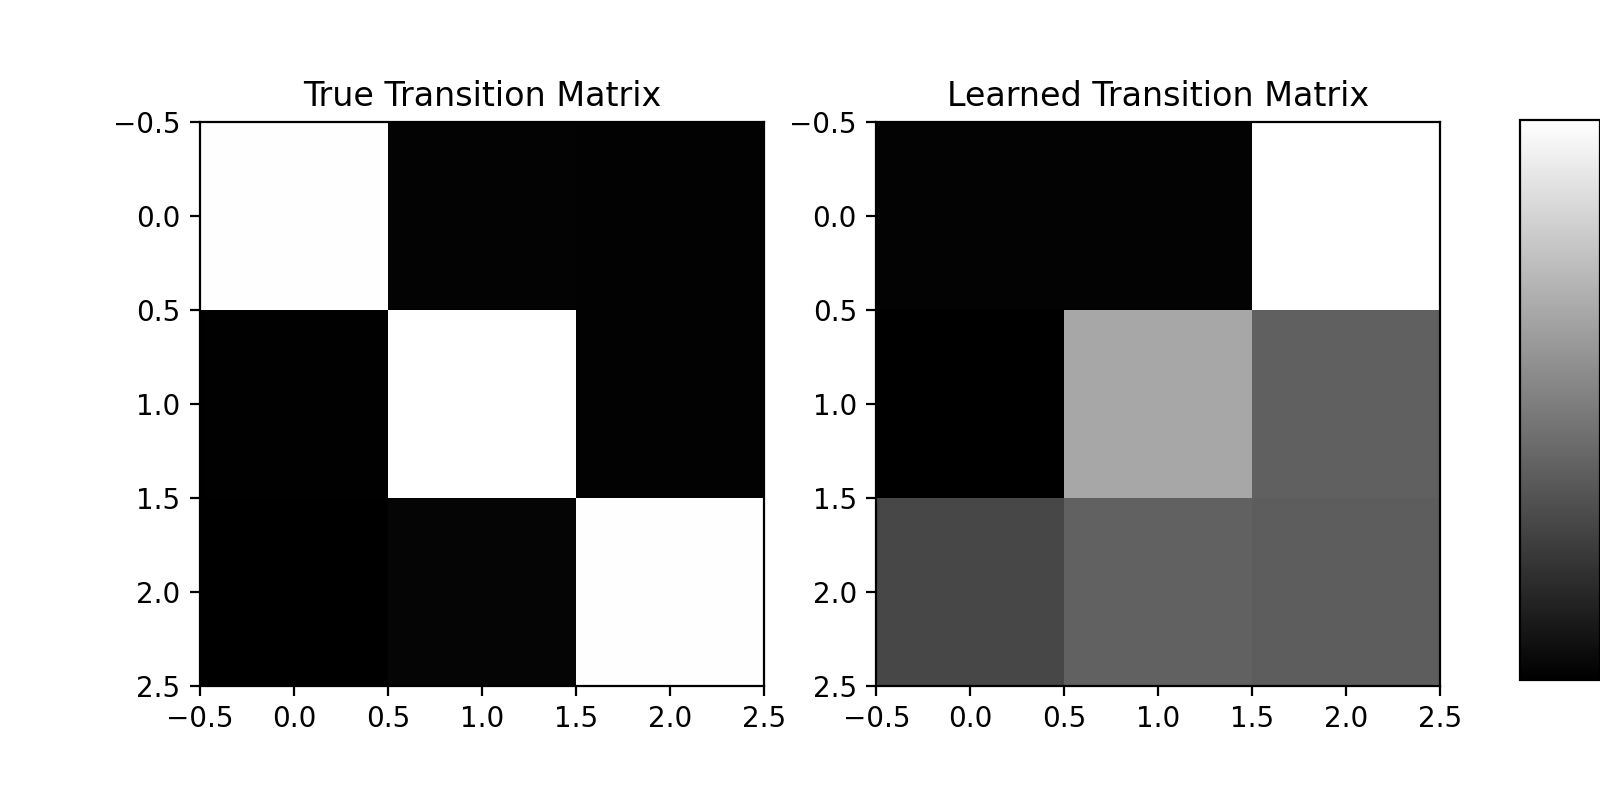

In [109]:
# Note: rows correspond to origin state, columns are destinations
# so that (i,j) entry corresponds to P(z_t+1 = j | z_t = i)
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


## Fit to animal behavior

<IPython.core.display.Javascript object>


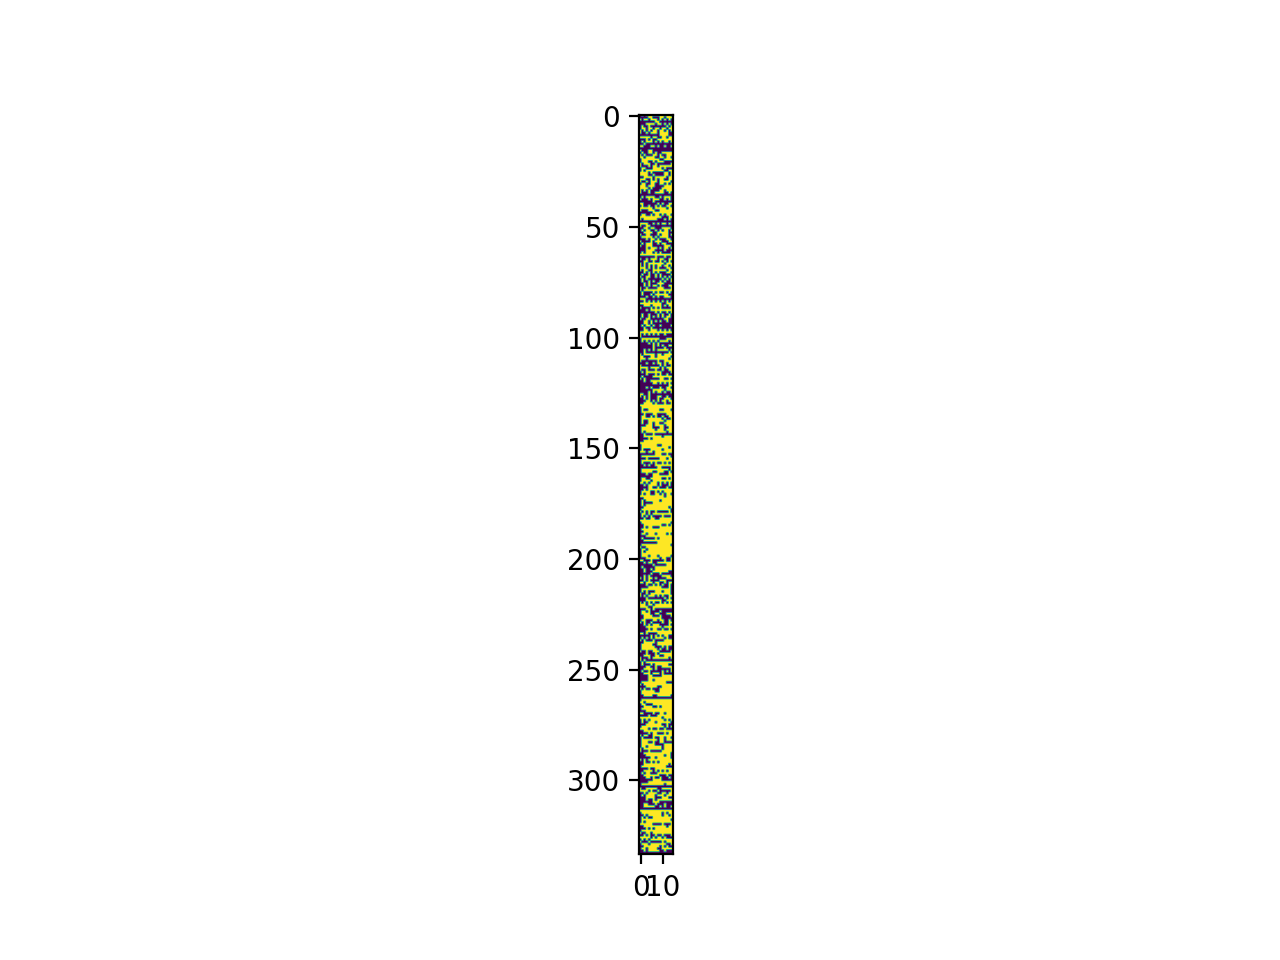

In [29]:
#TODOs:
# -Handle nan choices
# - Faster optimization and avoid local minima?

# Load data
filepath = '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expdata/f02_all_sessions.mat'
fitrange = np.arange(7,30)
# obs = load_session(filepath, 28)
obs, lengths, dirs = load_multiple_sessions(filepath, fitrange)
# plt.imshow(choicearr)

plt.figure()
plt.imshow(obs)

In [30]:
N_iters = 3000
obs_dim = obs.shape[1]
num_states = 4

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.figure()
plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/minhnhatle/Documents/ExternalCode/ssm/ssm/optimizers.py:149: UserWarning: L-BFGS-B failed with message:
ABNORMAL_TERMINATION_IN_LNSRCH
  warn("{} failed with message:\n{}".format(method, result.message))


AssertionError: 

<IPython.core.display.Javascript object>


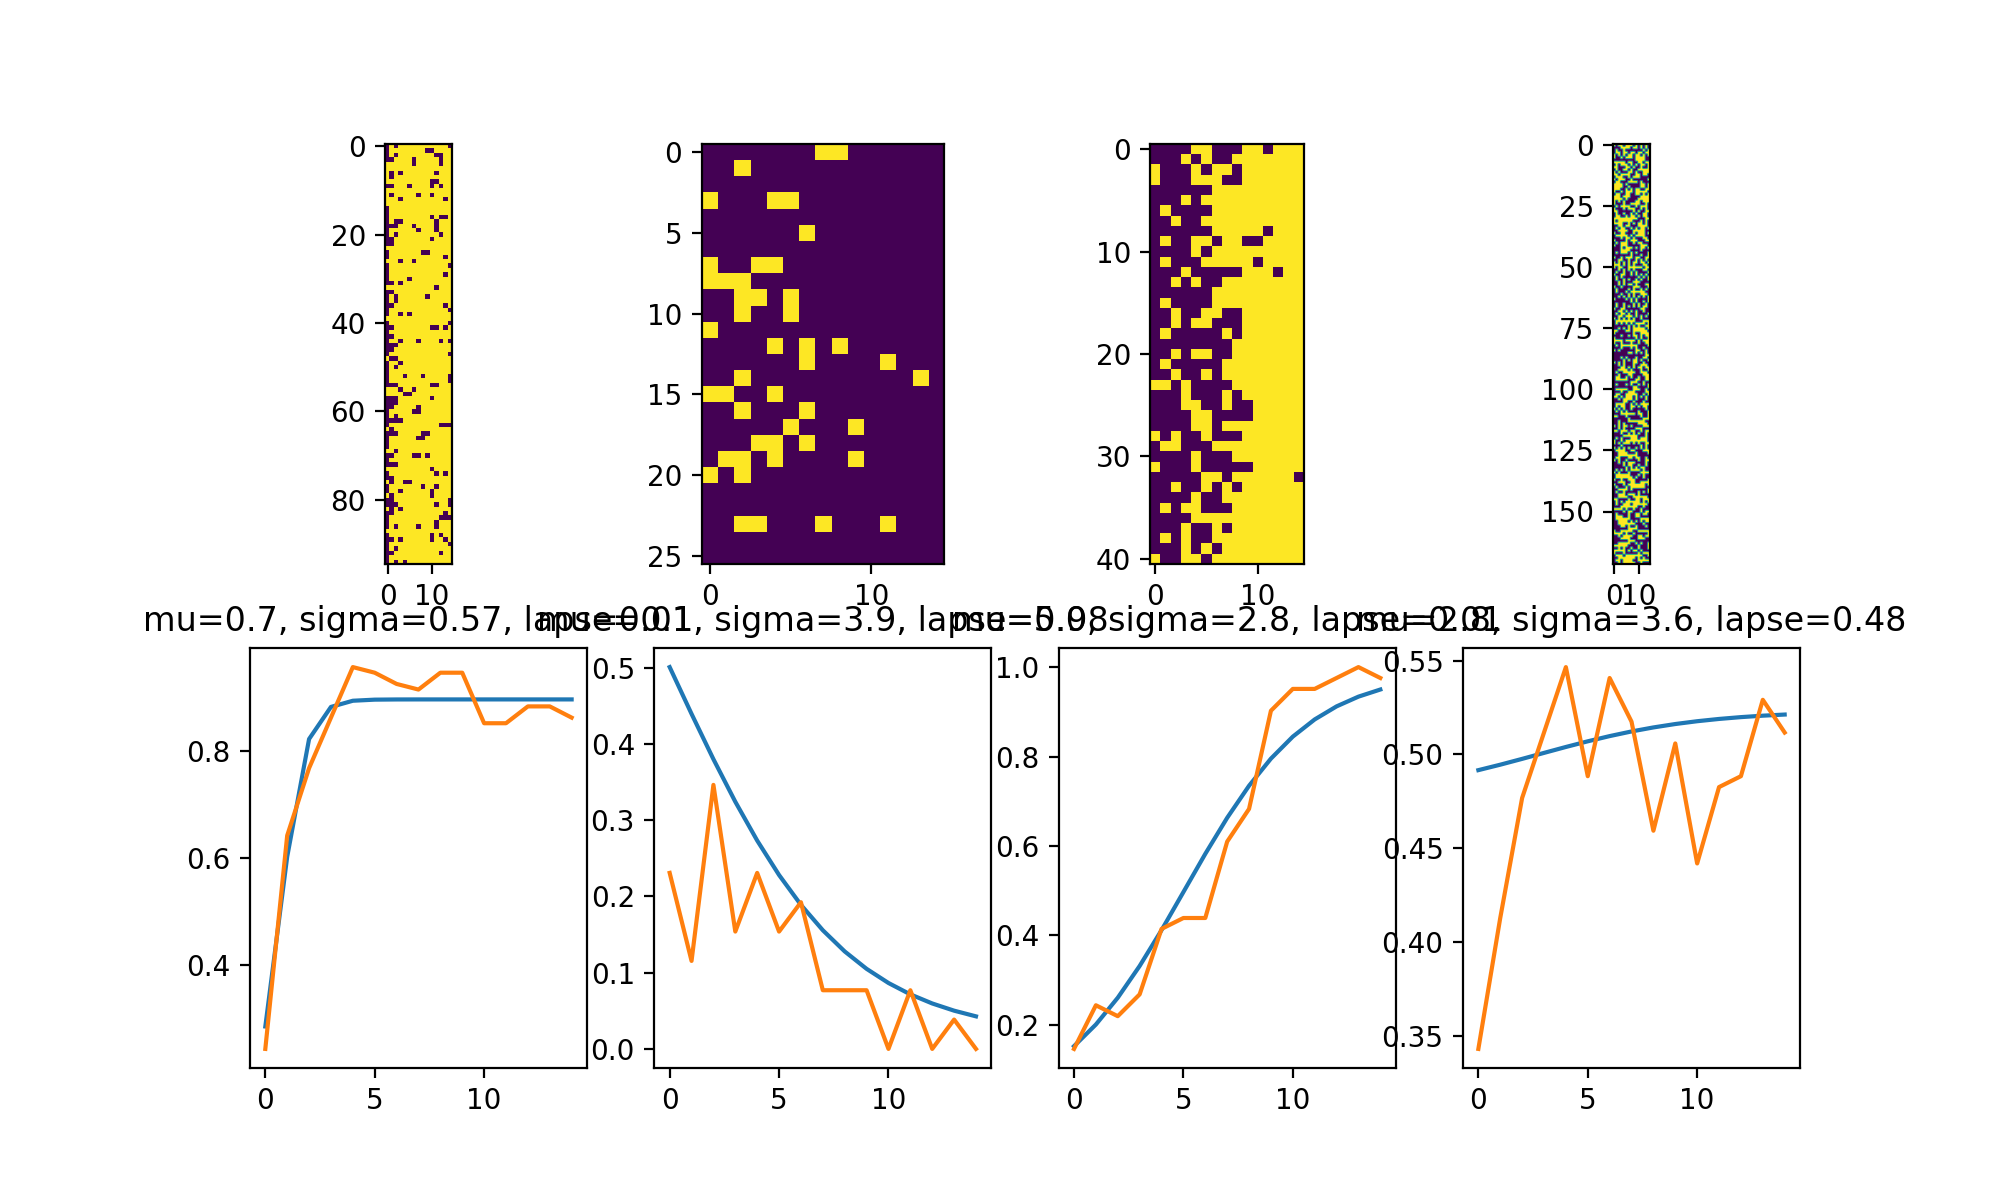

In [57]:
def sigmoid(x, mu, sigma, lapse=0):
    return lapse + (1-2*lapse) / (1 + np.exp(-(x - mu) / sigma))

# hmm.permute([1,3,0,2])

# Pool states and visualize
zstates = hmm.most_likely_states(obs)
obs_clustered = list(map(lambda x: obs[(zstates == x),:], np.unique(zstates)))

# Construct the block transition function for each mode
mus, sigmas, lapses = hmm.observations.params

transfuncs = list(map(lambda mu,sigma, lapse: sigmoid(np.arange(15), mu, sigma, lapse), mus, sigmas, lapses))
plt.figure(figsize=(10,6))

for i in range(num_states):
    plt.subplot(2,num_states,i+1)
    plt.imshow(obs_clustered[i])
    
    plt.subplot(2, num_states, i+1+num_states)
    plt.plot(transfuncs[i])
    plt.plot(np.nanmean(obs_clustered[i], axis=0))
    
    plt.title(f'mu={mus[i][0]:.2}, sigma={sigmas[i][0]:.2}, lapse={lapses[i][0]:.2}')
    


In [64]:
zstates

array([0, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 1, 3, 3, 3, 0, 3,
       3, 2, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 2,
       2, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 0, 0, 3,
       2, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 0,
       0, 3, 0, 3, 3, 0, 0, 2, 0, 3, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 3,
       0, 2, 0, 3, 2, 3, 0, 3, 3, 2, 3, 0, 3, 3, 3, 0, 3, 3, 0, 0, 0, 2,
       0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 3, 3, 2, 3, 2, 2, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0,
       3, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3,
       3, 2, 3, 3, 1, 0, 3, 2, 3, 3, 3, 2, 0, 2, 0, 0, 0, 2, 0, 0, 3, 1,
       0, 0, 2, 0, 0, 0, 3, 2, 0, 3, 3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 3, 0,
       0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 3, 2, 3, 3, 3,

<IPython.core.display.Javascript object>


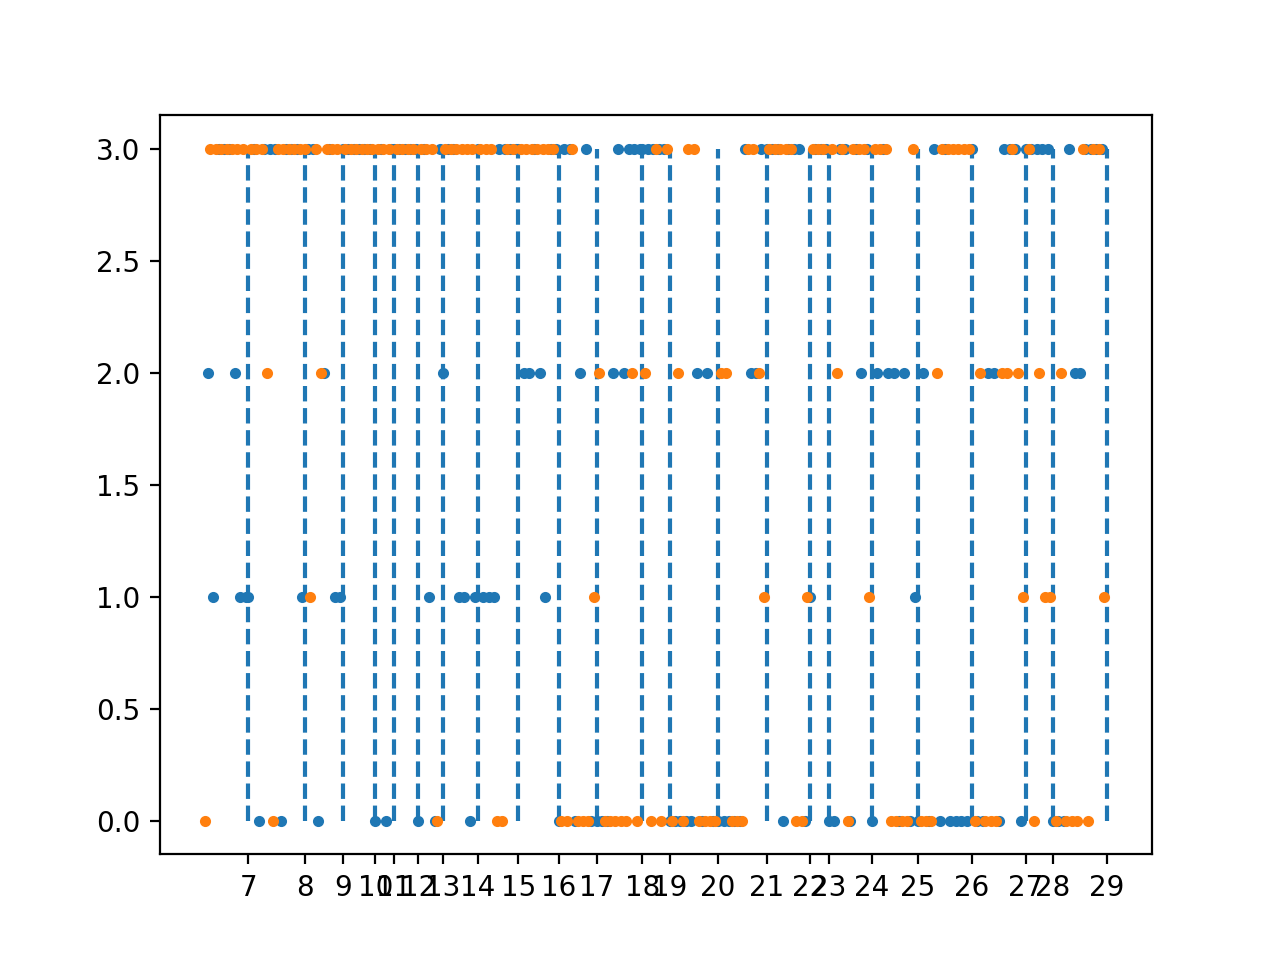

In [58]:
plt.figure()
pos = np.arange(len(zstates))
plt.plot(pos[dirs == 0], zstates[dirs == 0], '.')
plt.plot(pos[dirs == 1], zstates[dirs == 1], '.')

plt.vlines(np.cumsum(lengths), 0, 3, linestyles='--');

plt.xticks(ticks=np.cumsum(lengths), labels=np.arange(7,30));
# plt.xlim([0, 200])




In [63]:
# Save the result
transmat = hmm.transitions.transition_matrix
params = hmm.observations.params
savepath = '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expdata/f02_hmmblockfit.mat'

vars = ['zstates', 'dirs', 'lengths', 'transmat', 'params', 'fitrange', 'filepath', 'obs']
savedict = make_savedict(vars, globals())
# scipy.io.savemat(savepath, savedict)


In [49]:
savedict

{'lengths': [16,
  21,
  14,
  12,
  7,
  9,
  9,
  13,
  15,
  15,
  14,
  17,
  10,
  18,
  18,
  16,
  7,
  16,
  17,
  20,
  20,
  10,
  20],
 'dirs': array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1.